# Predicting 2016 - 2017 All-NBA Teams (End-To-End)
## Introduction
Hello all. This must be getting tiring if _**ANYBODY**_ has actually made it this far into this series of posts at this point.

![](https://i.giphy.com/media/sZaMhPd7mdkVa/giphy.webp)

How perfect... Lary David is even at _**A BASKETBALL GAME**_. I wanted to create one final post to summarize my objective and findings. I've been all over the place since I started this series of posts, but mostly because my objective was to _**learn something**_, plain and simple. I started out just knowing that I wanted to do something with machine learning and basketball, and now I've latched onto this idea of predicting all-NBA players which has been a great learning experience for a novice like me. Novice may be overselling myself actually...

The objective of the model is simple: Take historical data for each player across the seasons and see how the stat sheet affects their chances of either making All-NBA first, second, or third teams. For summarization and presentation purposes, I wanted to review all the important steps in our process in a single post. This should even help me refer back to the end-to-end code when I need to!

## Initial Setup & Config

In [1]:
# Initial setup & config

# Allow matplotlib inline graphing
%matplotlib inline

# Useful data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Seaborn makes our plots prettier
import seaborn
seaborn.set(style = 'ticks')

# Useful machine learning libraries
import xgboost as xgb
from xgboost import plot_importance
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Misc libraries
import datetime
import copy

## Gathering & Exploring Player Stats Data
To collect the data, I will have to scrape basketball-reference. They have some pretty cool data dating way back:
- For each year, for each player:
    - Per game stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_game.html](http://www.basketball-reference.com/leagues/NBA_2017_per_game.html)
    - Per 36 min stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_minute.html](http://www.basketball-reference.com/leagues/NBA_2017_per_minute.html)
    - Per 100 poss stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_poss.html](http://www.basketball-reference.com/leagues/NBA_2017_per_poss.html)
    - Advanced stats - [http://www.basketball-reference.com/leagues/NBA_2017_advanced.html](http://www.basketball-reference.com/leagues/NBA_2017_advanced.html)
    
The per-player stats have each season on a separate page, with all the players listed. I'll have to do a few loops of code to run through all the seasons:
- Loop once for every season (let's stick with our previously determined filter of excluding everything before the 79-80 season because of incomplete stat tracking, and the 98-99 season specifically because of a shortened lock-out season).
    - Within each season, loop through the different pages of types of stats and pull
    
_**The next two sections of code take about a half hour to run... go get some coffee!**_

In [2]:
# Create a reference dictionary of the pages I'm out to scrape
playerStatsBaseUrl = 'http://www.basketball-reference.com/leagues/NBA_'
playerStatsUrlSuffix = {
    'perGameStats': '_per_game.html',
    'per36Stats': '_per_minute.html',
    'per100Stats': '_per_poss.html',
    'advancedStats': '_advanced.html'
}

# Create a list of years to scrape through, to the current year
#   Unfortunately, I've been using the start year of a season (e.g. for the 98-99 season, I've been calling that season "1998")
#   basketball-reference uses the latter year as the identifier... I'm going to stick with my own convention, but I will have to
#      use their convention to scrape the pages for now
currentYear = datetime.datetime.now().year
years = range(1980, currentYear + 1)    # Remember that this is the 1979-1980 season to 2016-2017
years.remove(1999)    # Remove the 98-99 lockout season

print years

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [3]:
# Iterate through NBA seasons to get player stats
#   1. For each season
#       a. Get different types of stats
#       b. Concatenate stats by rows (horizontally)
#   2. Aggregate stats of all seasons into a single pandas dataframe (vertically)
seasonAggDf = None

for year in years:
    seasonStatsAggDf = None

    for playStatName, playerStatUrl in playerStatsUrlSuffix.iteritems():
        # Format URL to scan
        urlToScan = '{}{}{}'.format(
            playerStatsBaseUrl,
            year,
            playerStatUrl
        )

        # Pull data from HTML table
        #   Notice here we do not make the first row the header because we need that row of data to compare
        #   and drop duplicate headers in the middle of the table
        playerStatsDf = pd.read_html(
            io = urlToScan,
            header = None,
            attrs = {'class': 'stats_table'}
        )[0]

        # Fix some formatting issues (extra header rows in the middle of table) from bball ref
        playerStatsDf = playerStatsDf[playerStatsDf['Player'] != 'Player']
        playerStatsDf.reset_index(inplace = True)

        # Fix some formatting issues (extra columns) from bball ref
        if u' ' in playerStatsDf.columns:
            playerStatsDf.drop(u' ', axis = 1, inplace = True)
        if u' .1' in playerStatsDf.columns:
            playerStatsDf.drop(u' .1', axis = 1, inplace = True)

        # Since we are appending data from multiple tables, we append a prefix to each column table in order to
        #   preserve which columns came frmo which tables
        playerStatsDf.columns = ['{}_{}'.format(str(playStatName).encode('utf-8'), str(col).encode('utf-8')) for col in playerStatsDf.columns]

        # Aggregate stats dataframes
        if seasonStatsAggDf is None:
            seasonStatsAggDf = playerStatsDf
        else:
            seasonStatsAggDf = pd.concat([seasonStatsAggDf, playerStatsDf], axis = 1)

    # Aggregate stats dataframes
    seasonStatsAggDf['season_start_year'] = year - 1
    
    if seasonAggDf is None:
        seasonAggDf = seasonStatsAggDf
    else:
        seasonAggDf = pd.concat([seasonAggDf, seasonStatsAggDf], axis = 0)

    print 'Finished scraping {}'.format(year)

Finished scraping 1980
Finished scraping 1981
Finished scraping 1982
Finished scraping 1983
Finished scraping 1984
Finished scraping 1985
Finished scraping 1986
Finished scraping 1987
Finished scraping 1988
Finished scraping 1989
Finished scraping 1990
Finished scraping 1991
Finished scraping 1992
Finished scraping 1993
Finished scraping 1994
Finished scraping 1995
Finished scraping 1996
Finished scraping 1997
Finished scraping 1998
Finished scraping 2000
Finished scraping 2001
Finished scraping 2002
Finished scraping 2003
Finished scraping 2004
Finished scraping 2005
Finished scraping 2006
Finished scraping 2007
Finished scraping 2008
Finished scraping 2009
Finished scraping 2010
Finished scraping 2011
Finished scraping 2012
Finished scraping 2013
Finished scraping 2014
Finished scraping 2015
Finished scraping 2016
Finished scraping 2017


In [6]:
# First, I'll just grab some columns that look useful to me
playerAggDfToAnalyze = seasonAggDf[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Pos',
    'perGameStats_Age',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_GS',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FG%',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_3P%',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2P%',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FT%',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TS%',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORB%',
    'advancedStats_DRB%',
    'advancedStats_TRB%',
    'advancedStats_AST%',
    'advancedStats_STL%',
    'advancedStats_BLK%',
    'advancedStats_TOV%',
    'advancedStats_USG%',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS/48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]]

# Remove spcial characters out of header
playerAggDfToAnalyze.columns = pd.Series(playerAggDfToAnalyze.columns).str.replace('%', 'Perc').str.replace('/', '')

# Convert numeric arguments to numeric
playerAggDfToAnalyze = playerAggDfToAnalyze.apply(lambda x: pd.to_numeric(x, 'ignore'))

playerAggDfToAnalyze.head()

,season_start_year,perGameStats_Player,perGameStats_Pos,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,...,advancedStats_TOVPerc,advancedStats_USGPerc,advancedStats_OWS,advancedStats_DWS,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP
0,1979,Kareem Abdul-Jabbar*,C,32,LAL,82,NaN,38.3,12.3,20.3,...,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8
1,1979,Tom Abernethy,PF,25,GSW,67,NaN,18.2,6.0,12.4,...,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1
2,1979,Alvan Adams,C,25,PHO,75,NaN,28.9,9.8,18.5,...,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5
3,1979,Tiny Archibald*,PG,31,BOS,80,80.0,35.8,6.3,13.0,...,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5
4,1979,Dennis Awtrey,C,31,CHI,26,NaN,21.5,2.3,5.0,...,24.8,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1


To prevent outliers in the data, I will reduce our sample to only players each season who have played a...
- Minimum of 20 games per season (~25% of the season)
- Minimum of 10 minutes per game on average (~20% of each game)

In [7]:
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

## Gathering & Exploring All-NBA Team Labels
All-NBA team information is cleanly laid out within basketball-reference [here](http://www.basketball-reference.com/awards/all_league.html).

It's all in one table, so that makes for easy scraping, but we see there are definitely some formatting considerations that we have to knock down before going any further after scraping:
- Season will have to be cleaned up to only show the starting year of the season (to match our dataframe of players)
- The player names have the position following it, I'll have to strip the positions out as I'm not so concerned about these right now
- The format of the table is not what I'd like as well if I'm to join and look these values back up into the main dataframe table

Let's fix these.

In [5]:
# Format URL to scan
urlToScan = 'http://www.basketball-reference.com/awards/all_league.html'

# Pull data from HTML table
allNbaDf = pd.read_html(
    io = urlToScan,
    header = None,
    attrs = {'class': 'stats_table'}
)[0]

# Fix some formatting issues (extra header rows in the middle of table) from bball ref
allNbaDf = allNbaDf.dropna()
allNbaDf.columns = ['Season', 'Lg', 'Tm', 'C', 'F1', 'F2', 'G1', 'G2']

# Use pandas melt function to repivot to my desired format
allNbaDfFormatted = pd.melt(
    allNbaDf, 
    id_vars = ['Season', 'Lg', 'Tm'], 
    value_vars = ['C', 'F1', 'F2', 'G1', 'G2'],
    var_name = 'Position',
    value_name = 'Player'
)

# Fix remainder of formatting issues
#   Removing position from player name field (e.g. Lebron James F)
allNbaDfFormatted['Player'] = allNbaDfFormatted['Player'].replace(' [FCG]{1}$', '', regex = True)
allNbaDfFormatted['season_start_year'] = allNbaDfFormatted['Season'].apply(lambda x: x[:4])

allNbaDfFormatted = allNbaDfFormatted[[
    'season_start_year',
    'Tm',
    'Player'
]]

# Change season_start_year to int to match master dataframe
allNbaDfFormatted['season_start_year'] = allNbaDfFormatted['season_start_year'].astype(int)

allNbaDfFormatted.head()

,season_start_year,Tm,Player
0,2016,1st,Anthony Davis
1,2016,2nd,Rudy Gobert
2,2016,3rd,DeAndre Jordan
3,2015,1st,DeAndre Jordan
4,2015,2nd,DeMarcus Cousins


## Merge All-NBA Labels back into Players Stats
Okay, so I have the data now by player and year, and can probably join this back to the master dataframe. How do I join? Names is always an interesting field to join on because of its inconsistent nature.

Let's take the following names:
- Shaquille O'Neal
- Shaquille O Neal
- Shaq
- shaquille oneal

These are of course the same person, but neither me nor my computer are smart enough to perform this fuzzy matching at a large scale. Or rather, there's probably not the need to have to dive into that much detail when cleaning up the names are good enough for this specific use case.

If I make the assumption that these reference websites are using a players FULL NAMES
- Stephen Curry, not "Steph" Curry
- Carmelo Anthony, not "Melo"
- Shaquille O'Neal, not "Shaq O'Neal"

I think I'd basically just be able to change all characters to lower case and strip out anything not alphanumeric
- Stephen Curry becomes stephencurry
- Carmelo Anthony becomes carmeloanthony
- Shaquille O'Neal becomes shaquilleoneal

I don't believe I've ever seen two players with the exact same name in the all-star game, so there shouldn't be any duplicate joins... WELP, LET'S TRY THIS.

In [10]:
# Format player names in each dataframe to join
playerAggDfToAnalyzeMin10Min20Games['player_formatted'] = playerAggDfToAnalyzeMin10Min20Games['perGameStats_Player'].str.lower().replace('\W', '', regex = True)
allNbaDfFormatted['player_formatted'] = allNbaDfFormatted['Player'].str.lower().replace('\W', '', regex = True)

# Join dataframes
playerAggDfAllNba = playerAggDfToAnalyzeMin10Min20Games.merge(
    allNbaDfFormatted,
    how = 'left',
    on = ['player_formatted', 'season_start_year']
)

# Check data on sample of Lebron James
playerAggDfAllNba[playerAggDfAllNba['player_formatted'] == 'lebronjames'][[
    'perGameStats_Player',
    'player_formatted',
    'season_start_year',
    'Tm'
]]

playerAggDfAllNba.head()

/Users/chiwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,season_start_year,perGameStats_Player,perGameStats_Pos,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,...,advancedStats_DWS,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,player_formatted,Tm,Player
0,1979,Kareem Abdul-Jabbar*,C,32,LAL,82,NaN,38.3,12.3,20.3,...,5.3,14.8,0.227,4.0,2.7,6.7,6.8,kareemabduljabbar,1st,Kareem Abdul-Jabbar
1,1979,Tom Abernethy,PF,25,GSW,67,NaN,18.2,6.0,12.4,...,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,tomabernethy,NaN,NaN
2,1979,Alvan Adams,C,25,PHO,75,NaN,28.9,9.8,18.5,...,3.9,7.0,0.155,1.6,2.8,4.4,3.5,alvanadams,NaN,NaN
3,1979,Tiny Archibald*,PG,31,BOS,80,80.0,35.8,6.3,13.0,...,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,tinyarchibald,NaN,NaN
4,1979,Dennis Awtrey,C,31,CHI,26,NaN,21.5,2.3,5.0,...,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,dennisawtrey,NaN,NaN


At this point, we have a dataframe of per36, per100, per game, advanced stats, and All-NBA labels. The first thing I'm going to do is just generate a single label 'All-NBA' regardless of what team they made.

In [15]:
# Create column 'accolades_all_nba' to identify binary response for All-NBA status
playerAggDfAllNba['accolades_all_nba'] = np.where(
    pd.isnull(playerAggDfAllNba['Tm']),
    'Not All-NBA',
    'All-NBA'
)

playerAggDfAllNba[['Tm', 'accolades_all_nba']].head()

,Tm,accolades_all_nba
0,1st,All-NBA
1,NaN,Not All-NBA
2,NaN,Not All-NBA
3,NaN,Not All-NBA
4,NaN,Not All-NBA


## Building Model
In terms of choosing the right model I've found (through my tinkering) that I'm very drawn to trees in general. As [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf) states, Trees are fast to construct, interpretable, can handle numerical and categorical inputs, immune to outliers, and perform internal feature selection... The wet dream of data science! The only knock against trees is their accuracy vs other world-class models, but of course those models usually lose a bit of interpretability. The gradient boosted tree greatly enhances the single tree's ability to predict accurately and, while able to map nonlinear functions (inherently losing some of its interpretability), it still maintains all of the benefits above!

### Gradient Boosted Trees
![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/trees/2exampletree.png)

Trees make up the base of the classifier we are about to use, but first, we have to explore _**gradient boosting**_. Gradient boosting is essentially an ensemble method that superimposes a bunch of trees together. The main explanation I hear about gradient boosting, including how they introduce it in [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html), is that _**boosting**_ builds a _**committee**_ of votes by combining multiple _**weak learners**_. In general, the ensemble approach is analagous to the "ask the audience" option in "Who Wants to be a Millionaire". How many times have you seen the audience get a question wrong and the phone a friend guy get the answer wrong? The audience (albeit that lifeline is often used in the earlier stages of the game) is almost never wrong! Boosting takes this one step even further by making each of these learners an expert in one section of the data. It's like you can phone 100 friends, each of them being an expert at something. In fact, boosting is even crazier than that, after we've seen the question, we can then, in hindsight, _**pick a specific friend**_ who knows about the subject matter and increase our chances dramatically that way.

Before fully understanding boosting from ESL, I first stumbled upon this video by Alexander Ihler @ UC Irvine who does a beautiful job just visiualizing the steps of boosting.

We start out with a data set and we fit a very simple model. Here, our step function can essentially be seen like a 1 node tree.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/1boostingsteps.png" style="width: 400px;"/>

On the left hand side, we see our raw data. Here, we only have 1 feature (x axis) and an output (y axis). We "fit" the regression tree
- if $x<0.9$ then $y\approx -48$
- if $x>=0.9$ then $y\approx 5$

On the right hand side, we see the residuals of our first tree against our data. This is where our second learner comes in. In classic boosting, We then fit _**another**_ regression tree to the residuals.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/2boostingsteps.png" style="width: 400px;"/>

Our model then becomes our original tree plus some weighted version of our second tree.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/3boostingsteps.png" style="width: 400px;"/>

What do we do with this new model? That's right, we fit another tree to its residuals.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/4boostingsteps.png" style="width: 400px;"/>

What really ends up happening at the end of the day is that we'll start to build a model that gets closer and closer to the actual shape of the data. Like a neural network of sorts, we're essentially able to use something simple like a tree (depicted by a step function here) and sum more and more of them to build the model or decision boundary. If we took infinite trees, just like if we took infinite step functions or sigmoids, we can essentially build any function we want. Along with the neural network, boosting loses a bit of its interpretability because at the end of the day it can grow up to hundreds or thousands of trees, and good luck understanding the placement of each, but we'd see something like this:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/5boostingsteps.png" style="width: 700px;"/>

We see above that our residuals are shrinking more and more because all we've done here is take the latest model, _**find what its weaknesses are**_, and fit a model _**specifically geared towards fixing this weakness**_. In a sense, the newest tree at every iteration is _**trained to be an expert at everything the old model missed**_. Often, single node trees are used for the weak learners, so it takes a few iterations for the trees to start becoming experts at very specific portions of the data or even specific observations themselves, but in general the newest tree is picking up some of the slack of the sum of the previous trees.

_**Gradient**_ boosting is an extension of classic boosting where, instead of fitting the residuals, we define a _**loss function**_, as we always do, descend through the gradient to the hells of uninterpretable statistical accuracy. Amazing.

In the world of classification, there are a few loss functions that are usually used:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/6classificationloss.png" style="width: 400px;"/>

This plot is straight out of ESL and does a great job of visualizing how our misclassifications are being penalized.

In the case of misclassification loss, our rule is simple: We penalize a constant amount for wrong classifications, we don't penalize at all for correct classifications. We can see situations where this may not be ideal when our margin _**grossly**_ misclassifies by euclidean distance and we actually want to penalize far away misclassifications more severely than others. A $yf$ value of less than 0 is a misclassification, by the way, and above 0 is a correct classification.

If we look at squared error loss, we see that we'd actually be penalizing _**correct**_ classifications! This means that points _**well within**_ the correct side of the decision boundary will get penalized _**the more correct they are**_!

We then get into some of the more common misclassification loss functions, take deviance, where we don't penalize grossly wrong classifications as much (more robust to outliers) and we also penalize observations less and less the more correct they become.

xgboost is a library that allows us to build gradient boosted trees very easily. It is highly optimized and takes advantage of multithreading to speed up operations (although we won't necessarily need it for this use case as the data set is quite small)

### Training Our Data
To train our data, I first have to make some decisions about what I will be training and testing on.

My _**objective**_ again, is to predict the 2016 - 2017 All-NBA team using historical data, so I will hold our the 2016 season for my test set.

Among the remaining training set (1979 - 2015), I will take out an additional 10% to test for early stopping within xgboost. As our gradient boosted trees model continues to add trees, you could imagine a chance of overfitting and  wasting computational power when the tree has already found a good fit. xgboost allows us to employ an early stopping method where we can give it a train set to train against and a test set to evaluate against, and when the test error stops decreasing by a certain amount, we stop adding trees.

An extremely sketchy illustration of how I'm attempting to split my data up below:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/boosting/8traintestsplit.png)

### Cross Validation Strategy
With the NBA data, cross-validation should theoretically tell me how accurate my model is, right? Well, what is the objective I'm actually trying to solve? It can be approached in two ways:
1. If I'm just using the model_selection tools to perform straight cross validation (let's say 5-fold CV), I would have my data split 80% train and 20% test for five iterations. My measurement of correctness would not take into account that there are only 6 G's, 6 F's, and 3 C's that make the team.
2. If I take a step back, the real accuracy of my model should be averaged over all the years of data we have, because what we really care about is _**how many of the 15 players we got each year**_. To achieve measurement using this criteria, we must train the model on all the other ~29 years (I think we have around 30 years of data) and measure accuracy with a "leave-one-out" cross validation approach, where the one out is not necessarily one sample, but one year's worth of data.

There are two cases where cross-validation is useful:
1. To get a sense of the end-model accuracy
2. Tune parameters

Once I have my model, I can absolutely use the "leave-one-year-out" cross validation to gauge model score. If I tried to use the same approach for parameter tuning, I'd have 30x however many combinations of parameters I have. Even if I wanted to tune, let's say, 10 sets of parameters, I'd be training 300 model... this might be a bit too much.

I think to tune parameters, I'm going to just use _**GridSearchCV**_ from sklearn, and to measure overall model accuracy, I'll use the "leave-one-year-out" CV.

In [21]:
# Get ids of rows which are 2016 data
ids_2016 = playerAggDfAllNba[playerAggDfAllNba['season_start_year'] == 2016].index.tolist()

In [17]:
# Select braoder set of features manually
selectedCols = [
    'perGameStats_Age',
    'perGameStats_G',
    'perGameStats_GS',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FGPerc',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_3PPerc',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'accolades_all_nba'
]

playerAggDfAllNbaInitFeatures = playerAggDfAllNba[selectedCols]

In [18]:
# Split columns into x and y, y simply consists of the All-NBA labels
x_full = playerAggDfAllNbaInitFeatures.ix[:, playerAggDfAllNbaInitFeatures.columns != 'accolades_all_nba']
y_full = playerAggDfAllNbaInitFeatures['accolades_all_nba']

In [25]:
# Extract test set of only 2016 data
x_test = x_full[x_full.index.isin(ids_2016)]
y_test = y_full[y_full.index.isin(ids_2016)]

# Extract training set of everything except 2016 data
x_train_full = x_full[~x_full.index.isin(ids_2016)]
y_train_full = y_full[~y_full.index.isin(ids_2016)]

print 'x_test has shape {} and y_test has shape {}'.format(x_test.shape, y_test.shape)
print 'x_train_full has shape {} and y_train_full has shape {}'.format(x_train_full.shape, y_train_full.shape)

x_test has shape (428, 47) and y_test has shape (428,)
x_train_full has shape (12795, 47) and y_train_full has shape (12795,)


In [26]:
# Hold out 10% for xgboost early stopping test set using stratified train test split
x_train, x_test_early_stop, y_train, y_test_early_stop = train_test_split(x_train_full, y_train_full, test_size = 0.1, random_state = 1, stratify = y_train_full)

In [27]:
# Encode labels to 0 and 1
lb = LabelEncoder()

y_train_encoded = lb.fit_transform(y_train)
y_test_early_stop_encoded = lb.transform(y_test_early_stop)

print 'Y (train) set has the following labels {} and has {} elements'.format(np.unique(y_train_encoded), len(y_train_encoded))
print 'Y (test) set has the following labels {} and has {} elements'.format(np.unique(y_test_early_stop_encoded), len(y_test_early_stop_encoded))

Y (train) set has the following labels [0 1] and has 11515 elements
Y (test) set has the following labels [0 1] and has 1280 elements


In [28]:
# Fit our train and test data to a xgb sparse matrix
xgb_train = xgb.DMatrix(x_train, label = y_train_encoded)
xgb_test = xgb.DMatrix(x_test, label = y_test_early_stop_encoded)

We will use the GridSearchCV module from sklearn to perform 5-fold cross validated parameter selection on our data.

In [30]:
# Instantiate model
xgb_model = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_grid_search = {
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [10000]
}

fit_params = {
    'early_stopping_rounds': 100,
    'eval_metric': 'auc',
    'eval_set': [[x_test_early_stop, y_test_early_stop_encoded]],
    'verbose': 500
}

# Set up grid search
clf = GridSearchCV(
    xgb_model, 
    param_grid_search, 
    fit_params = fit_params,
    n_jobs = -1, 
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2, 
    refit = True
)

Train our model with 2 threads (the laptop I'm working off of only has 2 cores) capture cross validated errors of each parameter combination.

In [31]:
# Fit model
clf.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=1 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=1 
[0]	validation_0-auc:0.874146
Will train until validation_0-auc hasn't improved in 100 rounds.
[0]	validation_0-auc:0.832276
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[137]	validation_0-auc:0.993561

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=1 -   3.7s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=1 
[0]	validation_0-auc:0.856341
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[188]	validation_0-auc:0.992894

[C

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 -   4.4s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.970878
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[58]	validation_0-auc:0.993024

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 -   5.1s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.904016
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[65]	validation_0-auc:0.994374

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=3 -   4.4s
[CV] colsamp

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min


[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.970276
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[35]	validation_0-auc:0.993805

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   5.2s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.951317
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[33]	validation_0-auc:0.993317

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   5.0s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.

Stopping. Best iteration:
[67]	validation_0-auc:0.993415

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 -   8.1s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.961374
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[70]	validation_0-auc:0.993024

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 -   8.4s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.951724
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[25]	validation_0-auc:0.993057

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=bi

[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.941089
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[50]	validation_0-auc:0.994065

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 -   4.4s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.959431
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[58]	validation_0-auc:0.993935

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 -   4.3s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:

Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[47]	validation_0-auc:0.994325

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   6.0s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.961106
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[69]	validation_0-auc:0.993837

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   6.5s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.961341
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[46]	validation_0-auc:0.993366

[CV]  colsample_bytree=0.9, s

[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.968041
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[151]	validation_0-auc:0.993675

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=7 -  12.6s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.979699
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[50]	validation_0-auc:0.993772

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 -   7.5s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.96017

Stopping. Best iteration:
[139]	validation_0-auc:0.992406

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=1 -   2.9s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.903967
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[73]	validation_0-auc:0.994179

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 -   5.1s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=3 
[0]	validation_0-auc:0.96035
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[74]	validation_0-auc:0.994179

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=bina

[0]	validation_0-auc:0.970033
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[122]	validation_0-auc:0.993821

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 -  10.3s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.986285
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[43]	validation_0-auc:0.994211

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   6.4s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.969171
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[60]	validation_0-auc:0.993675

[CV]  

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.4min


[0]	validation_0-auc:0.96974
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[170]	validation_0-auc:0.993268

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -  11.8s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.987683
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[58]	validation_0-auc:0.992846

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   6.7s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.987211
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[39]	validation_0-auc:0.994374

[CV]  colsa

[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 
[0]	validation_0-auc:0.96865
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[32]	validation_0-auc:0.99335

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 -   8.3s
Stopping. Best iteration:
[53]	validation_0-auc:0.991642

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=7 -   9.2s


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.6min finished


[0]	validation_0-auc:0.968236
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[66]	validation_0-auc:0.993594



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_set': [[       perGameStats_Age  perGameStats_G  perGameStats_GS  perGameStats_MP  \
6818                 21              72             46.0             24.0
7560                 29              22             13.0             27.2
11002                25              55    ...ns], array([1, 1, ..., 1, 1])]], 'early_stopping_rounds': 100, 'eval_metric': 'auc', 'verbose': 500},
       iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': [0.8, 0.9, 1], 'silent': [1], 'learning_rate': [0.1], 'n_estimators': [10000], 's

In [34]:
# Print out the grid of scores
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

grid_scores_to_df(clf.grid_scores_).sort_values('score', ascending = False).head(10)

,colsample_bytree,fold,learning_rate,max_depth,n_estimators,objective,score,silent,subsample
159,1.0,4,0.1,5,10000,binary:logistic,0.994033,1,0.9
136,1.0,1,0.1,3,10000,binary:logistic,0.994026,1,0.8
76,0.9,1,0.1,3,10000,binary:logistic,0.993773,1,0.8
54,0.8,4,0.1,7,10000,binary:logistic,0.993736,1,0.9
51,0.8,1,0.1,7,10000,binary:logistic,0.993728,1,0.9
141,1.0,1,0.1,3,10000,binary:logistic,0.993704,1,0.9
59,0.8,4,0.1,7,10000,binary:logistic,0.993691,1,1.0
99,0.9,4,0.1,5,10000,binary:logistic,0.993666,1,0.9
139,1.0,4,0.1,3,10000,binary:logistic,0.993666,1,0.8
16,0.8,1,0.1,3,10000,binary:logistic,0.993664,1,0.8


Looking at the 10 best models in our parmeter tuning process, we quickly see that many of the folds yielded great scores. Let's see what the best model is:

In [35]:
# Best model
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 10000,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.9}

Because such a wide variety of models yielded high scores, I will go with what best\_params\_ picks! We now have our model! Gradient boosted trees have a great feature about them in that they can quantify the importance of features, thus performing internal feature selection. Because we're building trees upon trees, xgboost tracks the gains realized by splits of individual variables (and the fact that we're subsampling on features and sample help strengthen these measurements). They are presented in the importance plot.

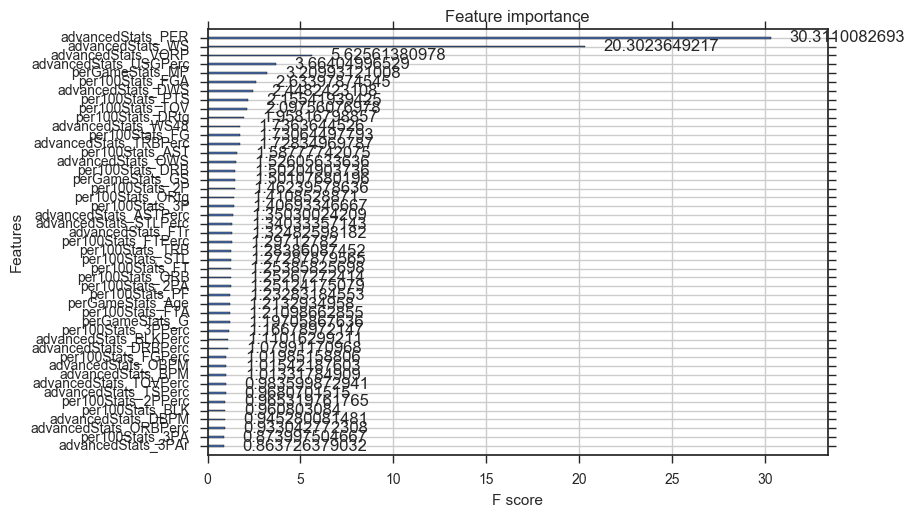

In [36]:
# Plot feature importance with xgboost
plot_importance(clf.best_estimator_, importance_type = 'gain')

The importance plot (using "gain" as the method of calculating importance, which measures the improvement of the models after making splits on that specific feature) shows that PER and WS are by far the most important splits, with VORP trailing. USG\%, along with all the other features follow but seem insignificant in comparison.

## Testing Model
### "Leave One Year Out" Cross Validation
Okay, so I have a model that seems to be doing pretty well. The next thing I need to do is go through each year and figure out what my final "accuracy" score is for this model. That is, what is the average amount of players I picked correctly out of the 15 chosen all-NBA players?

To re-iterate my point in the intro paragraphs, I can get a ranking of probabilities of how likely the model thinks the player is all-NBA, but it is not enough to _**simply pick the top 15 players that come up**_. What if the top 15 players with the best all-NBA probabilities are all guards? It's impossible to have an all-NBA team with only guards as per the definition of an all-NBA _**TEAM**_. I need to write a bit of logic to take the
- top 6 guards (2 per team)
- top 6 forwards (2 per team)
- top 3 centers (1 per team)

Also, there is an additional nuance in that the league, prior to the _**1988 - 1989**_ season, there were only _**two**_ all-NBA teams. Since then, there have been _**three**_ all-NBA teams. So, realistically, I will be counting the following:
- Before 1988 - 1989 season:
    - top 4 guards (2 per team)
    - top 4 forwards (2 per team)
    - top 2 centers (1 per team)
- 1988 - 1989 season to present:
    - top 6 guards (2 per team)
    - top 6 forwards (2 per team)
    - top 3 centers (1 per team)

Let's try it out.

In [37]:
# Merge season, player name, and position back into the cleaned dataframe
playerAggDfAllNbaInitFeaturesFullSet = playerAggDfAllNbaInitFeatures.merge(
    playerAggDfAllNba[['season_start_year', 'perGameStats_Player', 'perGameStats_Pos']],
    how = 'left',
    left_index = True,
    right_index = True
)

# Check results
playerAggDfAllNbaInitFeaturesFullSet.tail()

,perGameStats_Age,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_3PPerc,...,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba,season_start_year,perGameStats_Player,perGameStats_Pos
13218,28,74,74.0,30.2,8.1,15.4,0.527,1.0,2.6,0.381,...,4.6,0.100,0.0,1.4,1.4,1.9,Not All-NBA,2016,Thaddeus Young,PF
13219,24,62,58.0,27.8,7.4,12.9,0.571,0.0,0.0,0.000,...,5.6,0.157,-0.2,2.3,2.1,1.8,Not All-NBA,2016,Cody Zeller,PF
13220,27,51,5.0,10.3,7.4,14.9,0.494,0.0,0.1,0.000,...,1.0,0.094,-3.3,0.8,-2.5,-0.1,Not All-NBA,2016,Tyler Zeller,C
13221,22,44,18.0,19.2,5.3,13.2,0.398,2.0,5.9,0.333,...,0.5,0.030,-3.6,-0.1,-3.7,-0.4,Not All-NBA,2016,Paul Zipser,SF
13222,19,38,11.0,16.0,10.1,19.0,0.529,0.0,0.2,0.000,...,1.1,0.086,-2.7,0.3,-2.5,-0.1,Not All-NBA,2016,Ivica Zubac,C


In [39]:
# Unique years
unique_years_list = playerAggDfAllNbaInitFeaturesFullSet['season_start_year'].unique().tolist()
print 'There are {} seasons from {} to {}'.format(len(unique_years_list), np.min(unique_years_list), np.max(unique_years_list))

There are 37 seasons from 1979 to 2016


Let's first calculate the probabilities of all-NBA team selection based on the model we built. I'll generate the probabilities using GridSearchCV's predict\_proba method.

In [52]:
# Calculate all-star probabilities for our entire data set
#    Build test data to model on (filter for year)
x_cv_accuracy_full = copy.deepcopy(playerAggDfAllNbaInitFeaturesFullSet)
x_cv_accuracy_selected_features = x_cv_accuracy_full[playerAggDfAllNbaInitFeatures.columns]
x_cv_accuracy_no_labels = x_cv_accuracy_selected_features.drop('accolades_all_nba', 1)
print 'Input test set contains shape {}'.format(x_cv_accuracy_no_labels.shape)

# Make prediction using our xgboost model (best iteration is stored in clf with a predict_proba() method)
y_cv_accuracy_pred = clf.predict_proba(x_cv_accuracy_no_labels)
y_cv_accuracy_pred_df = pd.DataFrame(y_cv_accuracy_pred, columns = ['all_NBA_proba', 'not_all_NBA_proba'])
print 'Predicted labels contains shape {}'.format(y_cv_accuracy_pred_df.shape)

# Merge predictions back into full data set so we can access positions and true labels
x_cv_accuracy_full['y_cv_accuracy_pred_proba'] = y_cv_accuracy_pred_df['all_NBA_proba'].tolist()

Input test set contains shape (13223, 47)
Predicted labels contains shape (13223, 2)


In [53]:
# Check results
x_cv_accuracy_full.head()

,perGameStats_Age,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_3PPerc,...,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba,season_start_year,perGameStats_Player,perGameStats_Pos,y_cv_accuracy_pred_proba
0,32,82,NaN,38.3,12.3,20.3,0.604,0.0,0.0,0.000,...,0.227,4.0,2.7,6.7,6.8,All-NBA,1979,Kareem Abdul-Jabbar*,C,0.996326
1,25,67,NaN,18.2,6.0,12.4,0.481,0.0,0.0,0.000,...,0.080,-1.5,-0.1,-1.6,0.1,Not All-NBA,1979,Tom Abernethy,PF,0.000005
2,25,75,NaN,28.9,9.8,18.5,0.531,0.0,0.0,0.000,...,0.155,1.6,2.8,4.4,3.5,Not All-NBA,1979,Alvan Adams,C,0.000625
3,31,80,80.0,35.8,6.3,13.0,0.482,0.1,0.3,0.222,...,0.148,1.1,-1.1,0.0,1.5,Not All-NBA,1979,Tiny Archibald*,PG,0.023388
4,31,26,NaN,21.5,2.3,5.0,0.450,0.0,0.0,NaN,...,0.053,-2.9,1.5,-1.4,0.1,Not All-NBA,1979,Dennis Awtrey,C,0.000015


In [54]:
# This function takes in a dataframe of the players' names, positions, and predicted probabiity of all-NBA and returns
#   the predicted team selected by the model
def select_team(x_cv_accuracy_full, year):
    # Define dict of number of players to select
    player_counters = {}
    
    # Define the number of guards to select depending on the year
    if year < 1988:
        player_counters['G'] = 4
    else:
        player_counters['G'] = 6
        
    # Define the number of forwards and centers to select (both dependent on guards)
    player_counters['F'] = copy.deepcopy(player_counters['G'])
    player_counters['C'] = copy.deepcopy(player_counters['G']) / 2
    
    # Define empty dataframe to store players we found
    all_nba_selected_df = None
    
    # Sort dataframe by y_cv_accuracy_pred_proba
    x_cv_accuracy_full.sort_values('y_cv_accuracy_pred_proba', ascending = False, inplace = True)
    
    print 'Year {}: Finding the top {} guards, {} forwards, and {} centers'.format(year, player_counters['G'], player_counters['F'], player_counters['C'])
    
    # Loop through each position and select top guards, forwards, and centers
    for position in player_counters:
        x_cv_accuracy_full_position = x_cv_accuracy_full[x_cv_accuracy_full['perGameStats_Pos'].str.contains(position)][['season_start_year', 'perGameStats_Player', 'perGameStats_Pos', 'accolades_all_nba', 'y_cv_accuracy_pred_proba']].head(player_counters[position])
        
        # Append the results from each position to the final results dataframe
        if all_nba_selected_df is None:
            all_nba_selected_df = copy.deepcopy(x_cv_accuracy_full_position)
        else:
            all_nba_selected_df = pd.concat([all_nba_selected_df, x_cv_accuracy_full_position])
    
    # Return dataframe of all selected players in the year
    return all_nba_selected_df

# Initiate empty dataframe to store all the predicted results
all_nba_all_year_predicted_df = None

# Loop and predict for every year, calculating the number of players predicted correctly
i = 1
for year in playerAggDfAllNbaInitFeaturesFullSet['season_start_year'].unique().tolist():
    print 'Starting year {}'.format(year)
    
    # Build test data to model on (filter for year)
    all_nba_selected_df = select_team(x_cv_accuracy_full[x_cv_accuracy_full['season_start_year'] == year], year)
    
    # Append the results from each year to the final results dataframe
    if all_nba_all_year_predicted_df is None:
        all_nba_all_year_predicted_df = copy.deepcopy(all_nba_selected_df)
    else:
        all_nba_all_year_predicted_df = pd.concat([all_nba_all_year_predicted_df, all_nba_selected_df])

Starting year 1979
Year 1979: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1980


/Users/chiwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Year 1980: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1981
Year 1981: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1982
Year 1982: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1983
Year 1983: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1984
Year 1984: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1985
Year 1985: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1986
Year 1986: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1987
Year 1987: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1988
Year 1988: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1989
Year 1989: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1990
Year 1990: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1991
Year 1991: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1992
Year 1992: Findi

In [55]:
# Merge selections back into main data frame
all_nba_all_year_predicted_df['y_cv_accuracy_pred'] = 'All-NBA'

x_cv_accuracy_full = x_cv_accuracy_full.merge(
    all_nba_all_year_predicted_df[['y_cv_accuracy_pred']],
    how = 'left',
    left_index = True,
    right_index = True
)

In [56]:
x_cv_accuracy_full.head()

,perGameStats_Age,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_3PPerc,...,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba,season_start_year,perGameStats_Player,perGameStats_Pos,y_cv_accuracy_pred_proba,y_cv_accuracy_pred
0,32,82,NaN,38.3,12.3,20.3,0.604,0.0,0.0,0.000,...,4.0,2.7,6.7,6.8,All-NBA,1979,Kareem Abdul-Jabbar*,C,0.996326,All-NBA
1,25,67,NaN,18.2,6.0,12.4,0.481,0.0,0.0,0.000,...,-1.5,-0.1,-1.6,0.1,Not All-NBA,1979,Tom Abernethy,PF,0.000005,NaN
2,25,75,NaN,28.9,9.8,18.5,0.531,0.0,0.0,0.000,...,1.6,2.8,4.4,3.5,Not All-NBA,1979,Alvan Adams,C,0.000625,NaN
3,31,80,80.0,35.8,6.3,13.0,0.482,0.1,0.3,0.222,...,1.1,-1.1,0.0,1.5,Not All-NBA,1979,Tiny Archibald*,PG,0.023388,NaN
4,31,26,NaN,21.5,2.3,5.0,0.450,0.0,0.0,NaN,...,-2.9,1.5,-1.4,0.1,Not All-NBA,1979,Dennis Awtrey,C,0.000015,NaN


In [57]:
# The left join merge above leaves Non All-NBA selections as NaN, let's replace them with "Not All-NBA" to match y_test values
x_cv_accuracy_full['y_cv_accuracy_pred'].fillna('Not All-NBA', inplace = True)

In [61]:
# Check results
x_cv_accuracy_full[['accolades_all_nba', 'y_cv_accuracy_pred']].head()

,accolades_all_nba,y_cv_accuracy_pred
0,All-NBA,All-NBA
1,Not All-NBA,Not All-NBA
2,Not All-NBA,Not All-NBA
3,Not All-NBA,Not All-NBA
4,Not All-NBA,Not All-NBA


Okay, after that journey, we _**finally**_ have a _**table of player data with actual All-NBA labels and calculated All-NBA labels**_ that incorporate All-NBA team selection logic. Let's take a peek at the final results?

In [63]:
# Show tallies of predictions, for our dataframe of players who our model selected to be All-NBA, the actual labels were...
all_nba_all_year_predicted_df[all_nba_all_year_predicted_df['season_start_year'] != 2016]['accolades_all_nba'].value_counts()

All-NBA        476
Not All-NBA     19
Name: accolades_all_nba, dtype: int64

476 predicted correctly out of 495... that's good for <span style="color:red">_**96% accuracy!!!!!!**_</span>. And how did we do on our actual test set of the 2016 - 2017 season?

In [75]:
# Define set of columns to look at so we can make our analysis more concise
cols_to_view = [
    'perGameStats_Player',
    'perGameStats_Pos',
    'accolades_all_nba',
    'y_cv_accuracy_pred',
    'y_cv_accuracy_pred_proba'
]

# Show 2016 results
x_cv_accuracy_full[x_cv_accuracy_full['season_start_year'] == 2016].sort_values('y_cv_accuracy_pred_proba', ascending = False)[cols_to_view].head(40)

,perGameStats_Player,perGameStats_Pos,accolades_all_nba,y_cv_accuracy_pred,y_cv_accuracy_pred_proba
13197,Russell Westbrook,PG,All-NBA,All-NBA,0.997680
13037,Kawhi Leonard,SF,All-NBA,All-NBA,0.995279
12811,Giannis Antetokounmpo,SF,All-NBA,All-NBA,0.994502
12888,Anthony Davis,C,All-NBA,All-NBA,0.989796
12998,LeBron James,SF,All-NBA,All-NBA,0.987645
12858,Jimmy Butler,SF,All-NBA,All-NBA,0.985596
12939,Rudy Gobert,C,All-NBA,All-NBA,0.977380
12954,James Harden,PG,All-NBA,All-NBA,0.977036
12907,Kevin Durant,SF,All-NBA,All-NBA,0.974831
12886,Stephen Curry,PG,All-NBA,All-NBA,0.956186


Unfortunately, our model only predicted 12 / 15 correct All-NBA teamers here, good for 80%. Not a horrible number, but I wouldn't want to put my money on the line with this type of model.

My model picked:
- G - Dame
- F - Gordon Hayward
- C - KAT

The actual players selected were:
- G - IT
- F - Draymond Green
- C - Deandre Jordan

All 3 guys that my model picked were considered as "snubs" in the media as the awards were being handed out. KAT and Dame were probably the biggest snubs from what I can remember. There was mention of Hayward making the team, but at the end of the day you had to kick someone off, and even I agree with the Draymond pick myself. What's interesting, though, is that Draymond is _**so low**_ in our All-NBA prediction probability... Our model thinks that Draymond _**doesn't even have 1%**_ of making the All-NBA team! In reality, he's ironically and arguably the lifeblood of that Warriors team. Steph and KD will get theirs, but Draymond demonstrates the most leadership and does the most intangibles on the floor. Crazy how low he ranks in the model though...

There seemed to be consensus that Deandre "undeservedly" made it over KAT. So I'm okay with this misclassification.

Dame and IT is probably a tossup too. IT, being the size that he is, leading those Celtics to the 1st seed in the East... That's quite a feat, and arguably deserving of All-NBA.

Perhaps one improvement that we haven't factored into the model is _**team wins**_. Team wins would have likely bumped up IT and Draymond's predicted probabilities.

## Conclusion
I've been called a data scientist at work, and I immediately felt that I was being extremely oversold. There are people out there using millions of users' data to predict traffic patterns, or developing algorithms for image recognition, or predicting which movies you'd like to watch next while I sit here and write extremely simple SQL statements and pipe it into a Tableau graph... I mean, you can't help but think "what am I? Sure as hell not a data scientist!".

But, then, what is data science, and how can one be considered a data scientist without that sinking incapable feeling in their heart? A data scientist is part engineer, part mathematician, part software developer, part statistician, part business analyst, part logical thinker, part smart person, part person who will not jump off a cliff after nothing works... I mean, can one person even be all of these? Really, for me, I think what it comes down to is can you solve this problem. The methods I've been taught thus far (line graphs, YoY calculations, SQL "group by"...) have solved problems I've had in the past, but they just don't scream "SCIENCE" to me. A data scientist solves problems, and I would like to be one that can not only solve a straightforward business problem, but also take a more scientific approach to problems too.

If I look back on all the things I wanted to learn about when I set out analyzing NBA data, it seemed like a mountain of knowledge. After reading [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html), I felt much more comfortable diving into a project. After mucking around in this project, I'm amazed by every I've learned in a few short weeks looking back. I stated I wanted to focus on learning across 4 domains with this project, and I think I've achieved my goal!

### Development Tools
In terms of development tools, this was the first time I used Jupyter. This was also a huge learning experience for me within R and python. Jupyter gave me the superpower to switch between python and R and pass dataframes back and forth, just an amazing capability. I had done some modeling in past with R, so I felt comfortable with the Y ~ X1 + X2 syntax. Honestly, it seems that most folks are pretty split, and python has even overtaken R in Kaggle competitions now I believe, but regardless, I wanted to just pick a language and just learn it. I had already gotten a lot of ETL / data transformation experience in python because I had done a lot of it in my job, but I felt I had the initial knowledge for R and it doesn't hurt to know multiple languages anyways! At the end of the day, I learned to work with both R and the skeearn library, two tool I'm sure I'll come across again. Working in Jupyter has been great as well. Jupyter seems to make the code itself a bit less automatable because it's not necessarily just a script you can execute, but it goes without saying that the interpretability benefits that Jupyter brings has clearly improved my workflow rather than running entire scripts over and over again to see results of one command.

### Mathematics & Statistics
Mathematical knowledge goes hand in hand with machine learning, but they are really two different domains. Mathematics, removed from machine learning, is a theoretical science. Entire domains of knowledge like linear algebra make up the fundamental thought process of how to interpret something like linear regression. More complex ideas like the singular value decomposition or eigenvectors are the life blood of the PCA algorithm. Machine learning takes this knowledge and applies them to a problem, but there's no chicken and egg here... the mathematical concepts came first for sure. When we creep a bit into probability and statistics, there are so many words we saw so often working through all our models... distributions, covariance, collinearity, log-odds, entropy... All these were fundamental to some process during some algorithm, and you honestly don't even know how to tune your models if you don't have this underlying knowledge. As I was making my this post, I was also finishing up the ESL book, which was vital in tying together mathematics and machine learning.

### Machine Learning
Again, you gotta give it up for [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html) here. We've already covered math, so let's cover machine learning logic. This was probably the most I learned out of any of these domains over the entire post. I literally went through 10 posts outlining models as simple as me manually picking a decision boundary with the eye test, to something basic like a logistic regression, to way more complex ideas like the neural network and the gradient boosted trees. I got a sense of how easy it was to play and tune each model, how fast it took to run certain models, the pros and cons of certain models, and understood why trees were just so goddamn useful. At the end of the day, my gradient boosted trees correctly predicted 12 / 15 all-NBA players for the 2016-2017 season! This was for sure the sexy part of this whole experience, and it really did live up to it as I craved over AUC metrics, sensitivity rates, and specificity rates. I also got a sense of good experimentation procedures, not necessarily even in machine learning but in carrying out any experiment. Ensuring we used safeguards like cross-validation to prevent ourselves from overfitting and making incorrect assumptions. Tuning paramaeters so we could understand better the affects each knob has on each model. Ultimately, this was a lesson in making the right assumptions and identifying / mitigating risks so our model can be operational in the real world.

### Basketball
Ah yes, who could forget basketball... the whole topic that started it all. With basketball, I have a working knowledge. I've played for the better part of 14 years now, I love to watch basketball and I spend way too much time on r/nba every single day. I like to think that I have a pretty good intuition compared to your average fan. What the post did for me was it helped me look at the data and summarize ideas in ways that I never thought about. Just looking at simple bar graphs, for example, helped me understand just how much more prevalent the 3P shot was in today's game compared to the 90's and 00's - With teams like Houston almost shooting 50% of their FGA as 3PA! Performing PCA on player's stats and seeing the data broken down by position on the PCA bi-plot was another super cool way of making sense of data that I already had ideas about in my head. Plus, this actually arranges complex amounts of data into a lower dimension that we, humans, can make more sense of and actually act on and automate if we so choose to. Lastly, looking at all the individual statistics, advanced metrics, and throwing them into the models to predict all-NBA players. That was a doozie, and I learned so much from that. I learned a bit more about the advanced stats of WS and VORP among others, and got a sense of how these measurements came into play when the media voted for their all-NBA selections. The gradient boosted tree model provided a means to make sense of all these advanced stats and proved to us really clearly that there is some logical connection between how the media thinks when making these votes and how these advanced stats summarize the play of an individual in a similar fashion.